## Part VI: Test Model Predictions

In this section, some sample patients will be run through the SCT predictions for evaluation.

This will include:

1.  Evaluate both positive and negative predictions
2.  Compare v. Deterioration Index
3.  Compare Deterioration Index for postive and negative predictions

In [1]:
import time
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

### Load Dataset

In [2]:
LOAD_FROM_GDRIVE = True

In [3]:
# load test data only
if(LOAD_FROM_GDRIVE):
    # mount google drive to load data
    from google.colab import drive
    drive.mount('/content/drive')

    dataset_root = '/content/drive/MyDrive/Datasets/sepsis/prepared/'

    X_test = np.load(os.path.join(dataset_root, 'X_test.npy'))
    y_test = np.load(os.path.join(dataset_root, 'y_test.npy'))

else:
    # load from datalake (S3)
    !aws s3 cp $s3_datalake_path_prepared $local_data_path_csv --recursive --exclude "*" --include "*.npy"

    X_test = np.load(os.path.join(local_data_path_csv, 'X_test.npy'))
    y_test = np.load(os.path.join(local_data_path_csv, 'y_test.npy'))

Mounted at /content/drive


In [4]:
# refactor targets to work for modeling
y_test = y_test.reshape(-1,1)

### Interrogate DI v. Model Predictions (from SCT)

In [5]:
# load best SCT
best_model_sct = keras.models.load_model('/content/drive/MyDrive/Datasets/sepsis/models/xformer_cnn_tuned.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 514 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [6]:
# helper function to run prediction and return DI sequence
def predict_and_get_di_sequence(model, X):
  y_pred = model.predict(X)
  di_sequence = X[0, :, -3]
  return di_sequence, y_pred[0]

# helper function to plot DI
def plot_di_sequence(di_sequence, title):
  sns.lineplot(x=np.arange(len(di_sequence)), y=di_sequence)
  plt.title(title)
  plt.show()

# helper function to plot DI
def plot_di_positive_negative_sequences(positive_sequence, negative_sequence, positive_pred, negative_pred, title):
  fig, ax = plt.subplots(figsize=(8, 6))
  positive_label = "SCT Prediction: Positive Sepsis [" + str(np.round(positive_pred[0], 2)) + "]"
  negative_label = "SCT Prediction: Negative Sepsis [" + str(np.round(negative_pred[0], 2)) + "]"
  sns.lineplot(x=np.arange(len(positive_sequence)), y=positive_sequence, color='red', label=positive_label)
  sns.regplot(x=np.arange(len(positive_sequence)), y=positive_sequence, color='red', line_kws={'linestyle': ':'}, scatter=False)
  #ax.text(np.arange(len(positive_sequence))[-1], positive_sequence[-1], "hello")
  sns.lineplot(x=np.arange(len(negative_sequence)), y=negative_sequence, color='green', label=negative_label)
  sns.regplot(x=np.arange(len(negative_sequence)), y=negative_sequence, color='green', line_kws={'linestyle': ':'}, scatter=False)
  ax.legend()
  plt.title(title)
  plt.xlabel("Time Step (hour)")
  plt.ylabel("Deterioration Index (DI)")
  plt.show()

In [7]:
# get positive prediction example
sample_patient_pos = X_test[10:11]
sample_di_pos, sample_pred_pos = predict_and_get_di_sequence(best_model_sct, sample_patient_pos)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [8]:
# get negative prediction example
sample_patient_neg = X_test[0:1]
sample_di_neg, sample_pred_neg = predict_and_get_di_sequence(best_model_sct, sample_patient_neg)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


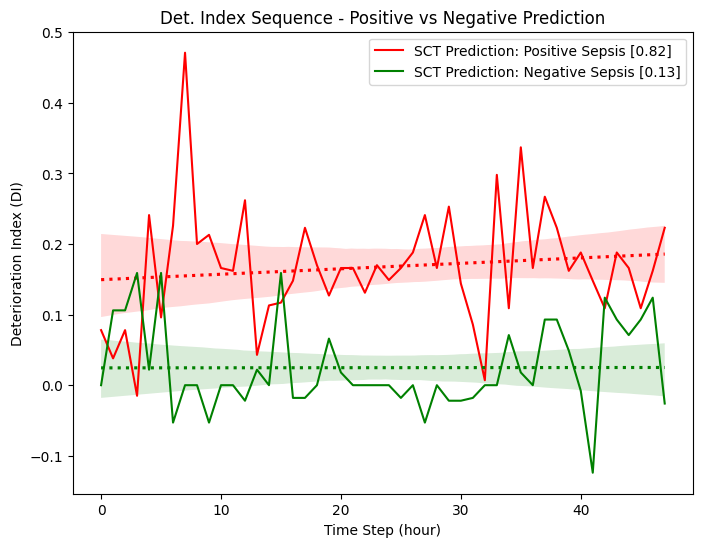

In [9]:
plot_di_positive_negative_sequences(sample_di_pos, sample_di_neg, sample_pred_pos, sample_pred_neg, "Det. Index Sequence - Positive vs Negative Prediction")

In [ ]:
# refactor targets to work for modeling
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
y_val = y_val.reshape(-1,1)

In [ ]:
# global default parameters
NUM_EPOCHS = 500
BATCH_SIZE = 64
LEARNING_RATE = 1e-4
input_shape = X_train.shape[1:]

# calculate class weights to handle class imbalance
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train.reshape(-1,))
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.6933899062081287, 1: 1.7927251732101617}